# Real-time Plotting of Twitter Sentiments

**Previously, I have shown how one can make use of the Twitter streaming API to obtain tweets based on a search term and extract sentiments, saving the data to a MySQL database. In this post, I will be demonstrating how one can apply the Matplotlib animation function to plot in real-time sentiments extracted from the twitter data.**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

%matplotlib nbagg

import MySQLdb
import authorization as credentials

In [2]:
#Matplotlib global settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [3]:
#db connection credentials
host = credentials.database['host']
user = credentials.database['user']
passwd = credentials.database['passwd']
unix_socket = credentials.database['unix_socket']
db = credentials.database['db']

**Set up the plot for the animation. Figure 1, subplot 1 is the average sentiment score obtained from adding up all the positive and negative scores in the database every 1 second. Subplot 2 is the total positive and total negative polarity, again obtained by taking the total scores for each polarity for all the tweets in the database. Figure 2 plots the total positive and negative sentiment each minute.**

<IPython.core.display.Javascript object>


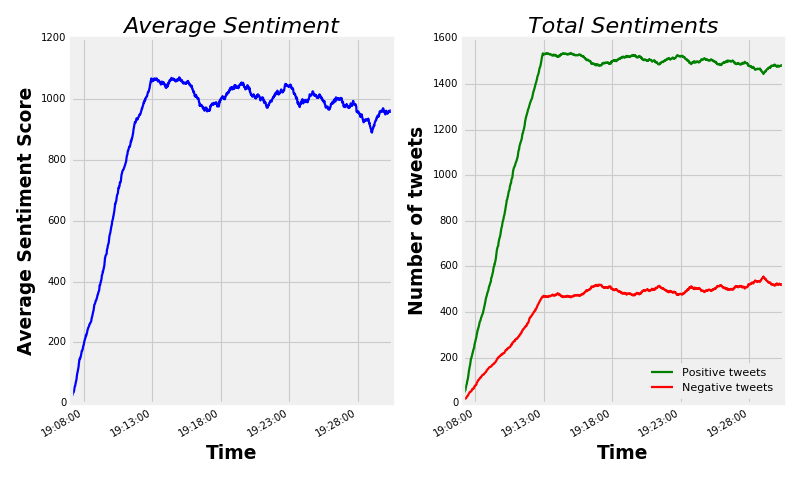

<IPython.core.display.Javascript object>


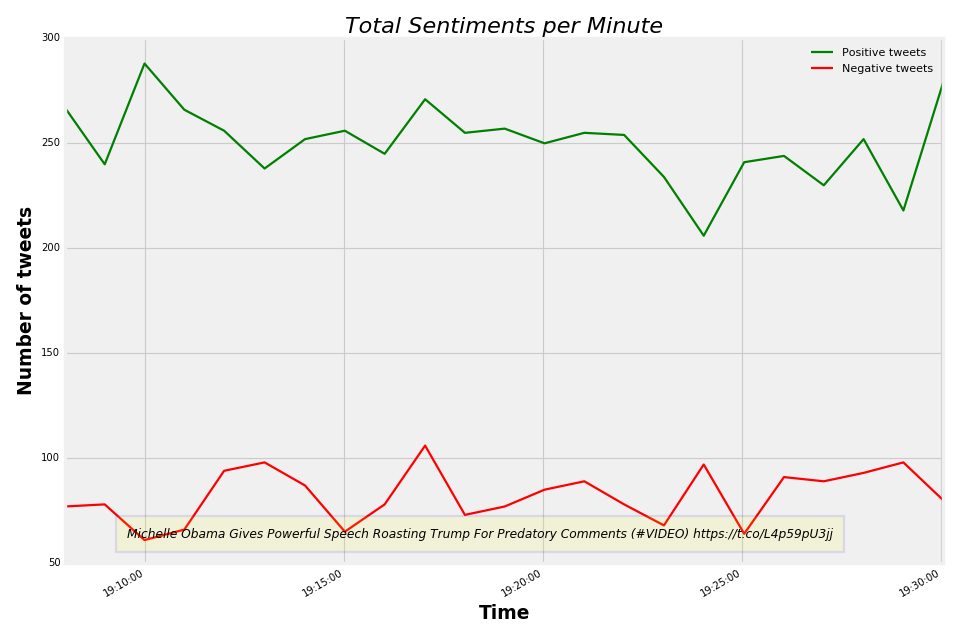

In [4]:
style.use('fivethirtyeight')

fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

fig2 = plt.figure(figsize=(12,8))
ax3 = fig2.add_subplot(1,1,1)
figText = plt.figtext(0.5, 0.16, '', family='serif', style='italic', wrap=True, 
                    horizontalalignment='center', fontsize=11,
                    bbox={'facecolor':'yellow', 'alpha':0.10, 'pad':10,
                          'edgecolor':'blue', 'linewidth': 2.0})

In [5]:
from datetime import datetime
from matplotlib.dates import DateFormatter,    \
                             AutoDateLocator,   \
                             HourLocator,        \
                             MinuteLocator   

def animate(i):
    """
    This is the animation function which takes the frame number i as a parameter
    """
    try:
        conn = MySQLdb.connect(host = host, user = user, passwd = passwd, unix_socket = unix_socket, db = db)
        cursor = conn.cursor()
        
        #Plot variables for Fig. 1
        cursor.execute("SELECT * FROM TwitterTrend")
        lines = cursor.fetchall()
        xtime = []
        ypos = []
        yneg = []
        yavg = []
        for line in lines:
            if len(line) > 1:
                pos = int(line[1])
                neg = int(line[2])
                avg = pos + neg
            
                dateTime = datetime.strptime(line[3],  "%Y-%m-%d %H:%M:%S.%f")
                dateTime = dateTime.replace(microsecond=0)
                xtime.append(dateTime)                        
                ypos.append(pos)
                yneg.append(abs(neg))
                yavg.append(avg)
 
        #Plot variables for Fig. 2
        cursor.execute("SELECT * FROM TwitterCurrent")
        results = cursor.fetchall()
        x_time = []
        y_pos = []
        y_neg = []
        for line in results:
            if len(line) > 1:
                pos_count = int(line[1])
                neg_count = int(line[2])
                
                dateTime = datetime.strptime(line[3],  "%Y-%m-%d %H:%M:%S.")
                x_time.append(dateTime)
                y_pos.append(pos_count)
                y_neg.append(neg_count)
                
                
        #Get the latest tweet
        cursor.execute("SELECT * FROM TwitterData")
        twitterData = cursor.fetchall()
        tweet = (twitterData[-1])[4]
        t = tweet.decode('utf-8')
       
        
        ax1.clear()
        ax1.plot(xtime, yavg, linewidth=2, color='blue', label='Average Score')
        ax1.set_xlabel('Time')
        ax1.xaxis.set_major_locator( AutoDateLocator() )
        ax1.xaxis.set_major_formatter( DateFormatter( '%H:%M:%S' ) )
        ax1.set_ylabel('Average Sentiment Score')
        ax1.set_title("Average Sentiment", fontstyle='italic')

    
        ax2.clear()
        ax2.plot(xtime, ypos, linewidth=2, color='green', label='Positive tweets')
        ax2.plot(xtime, yneg, linewidth=2, color='red', label='Negative tweets')
        ax2.set_xlabel('Time')
        ax2.xaxis.set_major_locator( AutoDateLocator() )
        ax2.xaxis.set_major_formatter( DateFormatter( '%H:%M:%S' ) )
        ax2.set_ylabel('Number of tweets')
        ax2.set_title("Total Sentiments", fontstyle='italic')
        ax2.legend(loc='best', numpoints=1, fancybox=True)
        
        
        ax3.clear() 
        ax3.plot(x_time, y_pos, linewidth=2, color='green', label='Positive tweets')
        ax3.plot(x_time, y_neg, linewidth=2, color='red', label='Negative tweets')
        ax3.set_xlabel('Time')
        ax3.xaxis.set_major_locator( AutoDateLocator() )
        ax3.xaxis.set_major_formatter( DateFormatter( '%H:%M:%S' ) )
        ax3.set_ylabel('Number of tweets')
        ax3.set_title("Total Sentiments per Minute", fontstyle='italic')
        ax3.legend(loc='best', numpoints=1, fancybox=True)

        #Text box for latest tweet
        figText.set_text(t)

        fig1.autofmt_xdate()
        fig1.tight_layout()   
        
        fig2.autofmt_xdate()
        fig2.tight_layout() 
        
        
    except (KeyboardInterrupt, SystemExit):
        raise

    except Exception as e:
        print(e.__doc__)

    finally:
        conn.close()
        

**Call the animation object with the blit keyword to ensure that we are only redrawing the parts of the plot that have changed. Also, save the animation as a video file.**

In [6]:
ani = animation.FuncAnimation(fig1, animate, interval=200, frames=100, blit=True)
ani.save('Figure1_averageSentiment.mp4', fps=30)
plt.show()



ani = animation.FuncAnimation(fig2, animate, interval=8000, frames=100, blit=True)
ani.save('Figure2_SentimentPerMin.mp4', fps=30)
plt.show()

